

## Objective:
To create an EDA/ feature-engineering starter notebook for toxic comment classification.

## Data Overview:
The dataset here is from wiki corpus dataset which was rated by human raters for toxicity.
The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015. 

Different platforms/sites can have different standards for their toxic screening process. Hence the comments are tagged in the following five categories
* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import warnings



#viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
# import matplotlib_venn as venn

#nlp
import string
import re    #for regex
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

# sys
import sys 
sys.path.append('../../')



#settings
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [2]:
#importing the dataset
train=pd.read_csv("../data/raw/train.csv")
test=pd.read_csv("../data/raw/test.csv")

In [3]:
#take a peak
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [8]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


There is a 51:49 train: test split.

Let's take a look at the class imbalance in the train set.

### Class Imbalance:

In [9]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [10]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


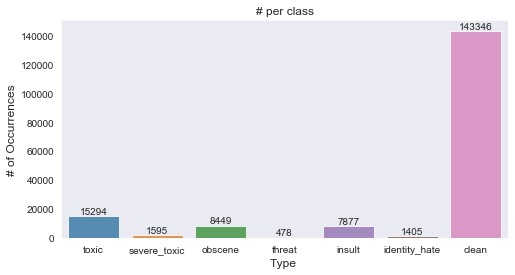

In [11]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

* The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
* There are ~95k comments in the training dataset and there are ~21 k tags and ~86k clean comments!?
    * This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene. 

### Multi-tagging:
Let's check how many comments have multiple tags.

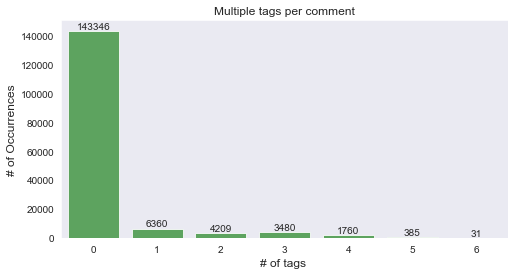

In [12]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Only ~10% of the total comments have some sort of toxicity in them. There are certain comments(20) that are marked as all of the above!




# Wordclouds - Frequent words:

Now, let's take a look at words that are associated with these classes.

   Chart Desc: The visuals here are word clouds (ie) more frequent words appear bigger. A cool way to create word clouds with funky pics is given [here](https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial).
    

In [18]:
stopword=set(STOPWORDS)

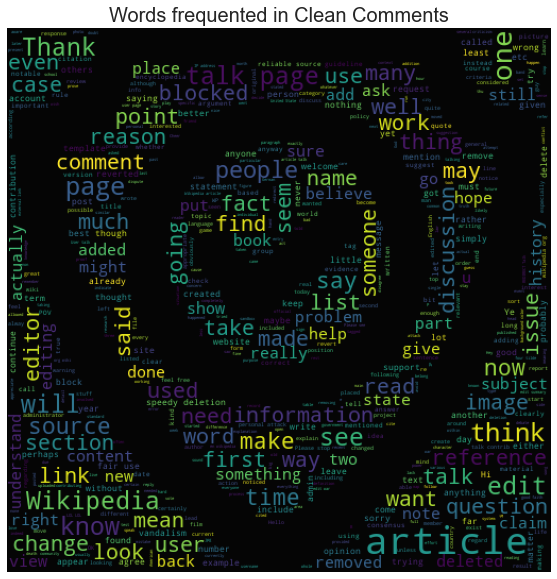

In [20]:
#clean comments
clean_mask=np.array(Image.open("../data/raw/images/safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

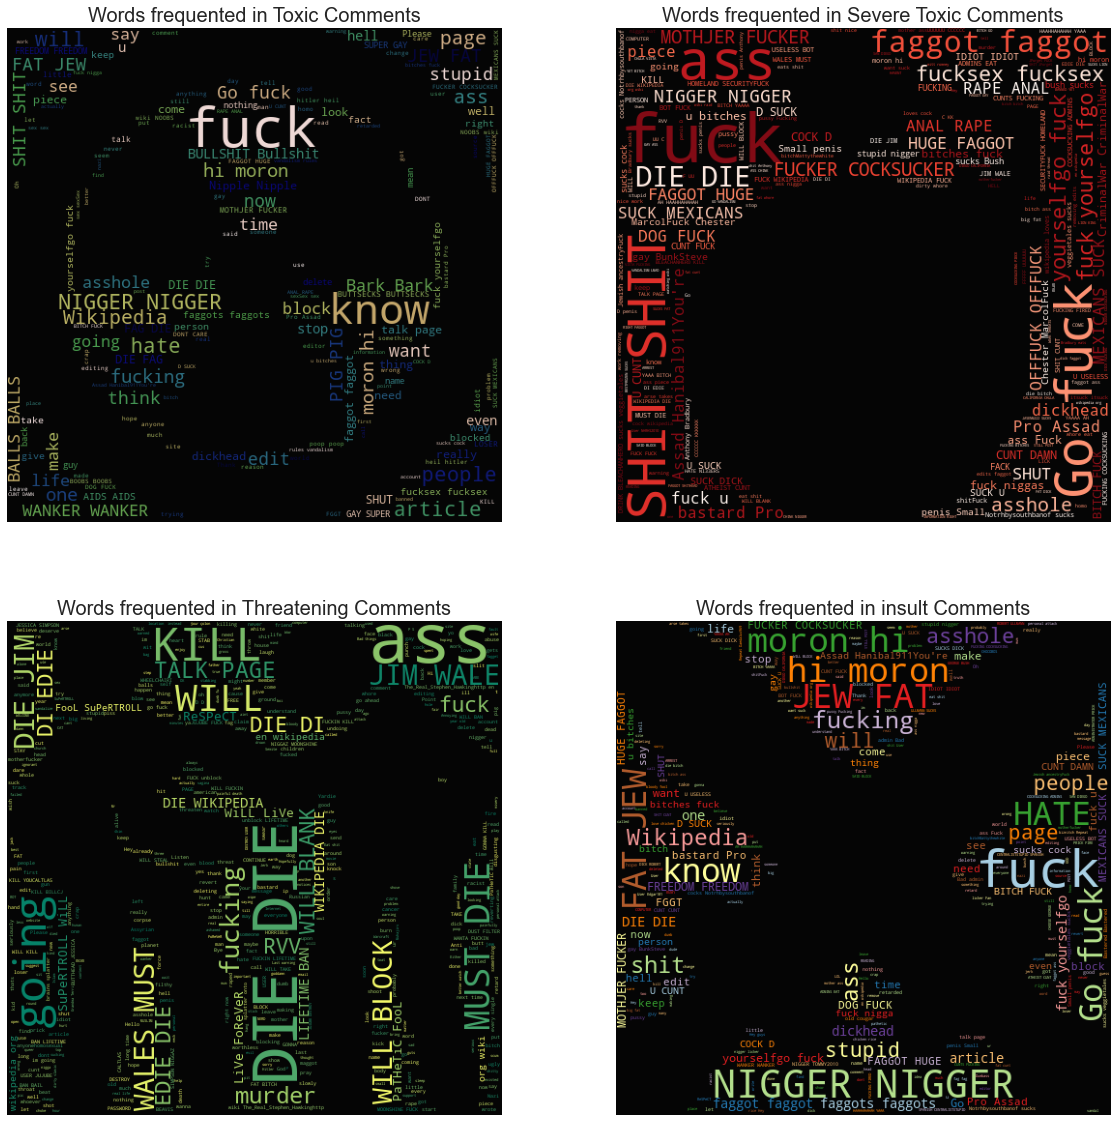

In [22]:
toxic_mask=np.array(Image.open("../data/raw/images/toxic-sign.png"))
toxic_mask=toxic_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,mask=toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
severe_toxic_mask=np.array(Image.open("../data/raw/images//bomb.png"))
severe_toxic_mask=severe_toxic_mask[:,:,1]
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
threat_mask=np.array(Image.open("../data/raw/images//anger.png"))
threat_mask=threat_mask[:,:,1]
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
insult_mask=np.array(Image.open("../data/raw/images/swords.png"))
insult_mask=insult_mask[:,:,1]
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()


In [ ]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [ ]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [24]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [30]:
#  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))

In [31]:
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

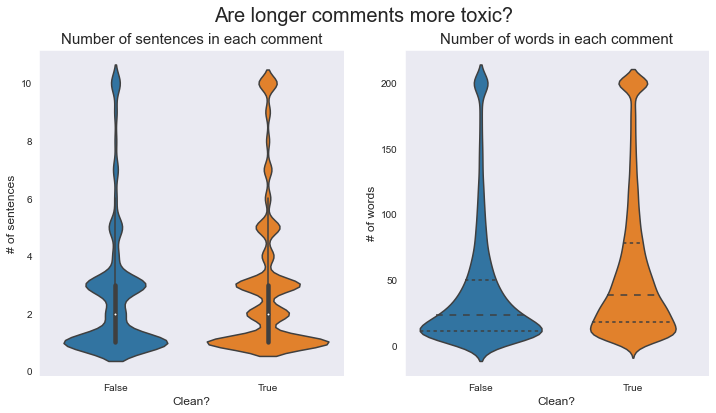

In [32]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

In [33]:
# Now let's clean our data

In [2]:
df_train=pd.read_csv('../data/modified/data_to_work_on.csv')
df_test = pd.read_csv('../data/modified/test.csv')

In [3]:
df_train

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [4]:
df_test

,comment_text
0,Yo bitch Ja Rule is more succesful then you'll...
1,== From RfC == \n\n The title is fine as it is...
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,":If you have a look back at the source, the in..."
4,I don't anonymously edit articles at all.
...,...
153159,". \n i totally agree, this stuff is nothing bu..."
153160,== Throw from out field to home plate. == \n\n...
153161,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,""" \n\n == """"One of the founding nations of the..."


In [153]:
from no_toxicity.src.preprocessing.cleaning import Dfcleaner

In [156]:
# Making the list of column to clean
raw_comments_train=df_train['comment_text'].to_list()
raw_comments_test=df_test['comment_text'].to_list()

In [157]:
# See the cleaning.py to see how it works
cleaner=Dfcleaner()

In [158]:
# cleaned_comments_train=cleaner.clean(raw_comments_train,stem=False)
cleaned_comments_test=cleaner.clean(raw_comments_test,stem=False)

10000 examples cleaned out of 153164
20000 examples cleaned out of 153164
30000 examples cleaned out of 153164
40000 examples cleaned out of 153164
50000 examples cleaned out of 153164
60000 examples cleaned out of 153164
70000 examples cleaned out of 153164
80000 examples cleaned out of 153164
90000 examples cleaned out of 153164
100000 examples cleaned out of 153164
110000 examples cleaned out of 153164
120000 examples cleaned out of 153164
130000 examples cleaned out of 153164
140000 examples cleaned out of 153164
150000 examples cleaned out of 153164
Cleaning Done


In [159]:
# cleaned_comments_train=cleaner.remove_frequent_rare(cleaned_comments_train,frequent=True,rare=True)
cleaned_comments_test=cleaner.remove_frequent_rare(cleaned_comments_test,frequent=True,rare=True)

10000 examples cleaned out of 153164
20000 examples cleaned out of 153164
30000 examples cleaned out of 153164
40000 examples cleaned out of 153164
50000 examples cleaned out of 153164
60000 examples cleaned out of 153164
70000 examples cleaned out of 153164
80000 examples cleaned out of 153164
90000 examples cleaned out of 153164
100000 examples cleaned out of 153164
110000 examples cleaned out of 153164
120000 examples cleaned out of 153164
130000 examples cleaned out of 153164
140000 examples cleaned out of 153164
150000 examples cleaned out of 153164
Cleaning Done


In [160]:
# Replacing the df column with new data
# df_train['comment_text']=cleaned_comments_train
df_test['comment_text']=cleaned_comments_test

In [161]:
# # Saving the cleaned data (don't run this cell)
# df_train.to_csv('../data/interim/cleaned_data_train.csv',index=False)
# df_test.to_csv('../data/interim/cleaned_data_test.csv',index=False)

In [11]:
# Load the data
train_df =pd.read_csv('../data/interim/cleaned_data_train.csv')
test_df =pd.read_csv('../data/interim/cleaned_data_test.csv')
# test_df_label = pd.read_csv('../data/raw/test_labels.csv')
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [12]:
# Let's make our own new feature
def new_col_value(row):
    flag=True
    # If the sample is toxic make it 0 and break else 1
    for i in row.iloc[1:]:
        if i==1:
            flag=False
            break
    if flag:
        return 1
    else:
        return 0


In [13]:
# Making the new feature
train_df['not_toxic']=train_df.apply(lambda row:new_col_value(row),axis=1)

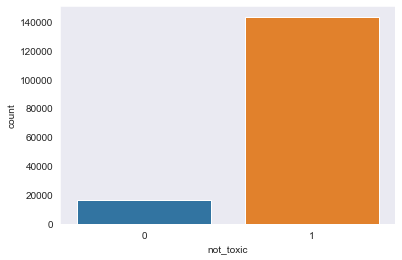

In [14]:
_=sns.countplot('not_toxic',data=train_df)

## We can clearly see our dataset is imbalanced so let's UnderSample our majority class

In [15]:
from imblearn.under_sampling import RandomUnderSampler

In [16]:
rus = RandomUnderSampler(random_state=42)
train_df,Y_label= rus.fit_resample(train_df.iloc[:,:-1],train_df.iloc[:,-1])
# train_df['not_toxic']=Y_label

In [17]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [18]:
train_df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,vandalize homer simpson continue block editing,0,0,0,0,0,0
1,nonsense medical condition fucking nonsense go...,1,0,1,0,1,0
2,awful awful german murderer blood million jew ...,1,0,1,0,1,1
3,go fuck james b watson winner overall pathetic...,1,0,1,0,1,0
4,idiot graceful slick need friend touch spot,1,0,1,0,1,0
...,...,...,...,...,...,...,...
32445,let review since grotesque offense start proba...,1,0,1,0,0,0
32446,pseudomonas stupid fucker,1,0,1,0,1,0
32447,accuse also note try usernames think could rem...,0,0,0,0,0,0
32448,redirect nelson cole,0,0,0,0,0,0


In [19]:
comment = train_df['comment_text']
comment = comment.values


In [20]:
label = train_df[['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']]

label = label.values

In [21]:
label

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 1],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(comment, label, test_size=0.2, random_state=42)


In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [24]:
x_train

array(['fuck god youn shit asshole',
       'okay stop see reason fault want keep crappy fraud loser disparages good hard work pianist go ahead guess really go toilet fuck sad see',
       'decline request account email see box top }}', ...,
       'category featured list candidate contest',
       'thanks block call tao idiot dumb bastard truly belive rule prevent harassment fine fun get system quit however seriously consider ndb lp rule dumb bastard lazy people currently laugh stock punchline joke reason facilitates lazy people like tao read entire entry intention improve provide source provide sound argument provide necessary provide circumstance like order improve tao provide nothing clearly read clearly know subject clearly uninterested need do circumstance like valid claim support evidence true take seriously believe potential anything believe harm substantial way tao hand insidious virus little undermine value world block genuine appeal block ask appeal actually read conversatio

In [48]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(x_train).toarray()
# examine the document-term matrix created from X_train
X_dtm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(x_test).toarray()
# examine the document-term matrix from X_test
test_X_dtm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [29]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

def evaluate_score(Y_test,predict, predict_prob): 
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    try : 
        loss = log_loss(Y_test,predict_prob)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))

1. BR with Logistic


In [92]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression()

# create submission file
pred_df = pd.DataFrame(columns=cols_target)
pred_prob_df = pd.DataFrame(columns=cols_target)
i=0
for label in cols_target:
    print('... Processing {}'.format(label))
    y = y_train[:,i]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    # print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    test_y = logreg.predict(test_X_dtm)
    pred_prob_df[label] = test_y_prob
    pred_df[label] = test_y
    i=i+1

... Processing obscene
... Processing insult
... Processing toxic
... Processing severe_toxic
... Processing identity_hate
... Processing threat


In [93]:
evaluate_score(y_test,pred_df.values, pred_prob_df.values)

Hamming_loss : 7.665639445300462
Accuracy : 66.33281972265023
Log_loss : 1.3559361809607506


2. BR with GuassianNB

In [94]:
# import and instantiate the Logistic Regression model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
logreg = GaussianNB()

# create submission file
pred_df = pd.DataFrame(columns=cols_target)
pred_prob_df = pd.DataFrame(columns=cols_target)
i=0
for label in cols_target:
    print('... Processing {}'.format(label))
    y = y_train[:,i]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    # print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    test_y = logreg.predict(test_X_dtm)
    pred_prob_df[label] = test_y_prob
    pred_df[label] = test_y
    i=i+1

... Processing obscene
... Processing insult
... Processing toxic
... Processing severe_toxic
... Processing identity_hate
... Processing threat


In [95]:
evaluate_score(y_test,pred_df.values, pred_prob_df.values)

Hamming_loss : 31.787365177195685
Accuracy : 26.856702619414484
Log_loss : 5.405492117928229


3. BR with MultinomialNB

In [96]:
# import and instantiate the Logistic Regression model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
logreg = MultinomialNB()

# create submission file
pred_df = pd.DataFrame(columns=cols_target)
pred_prob_df = pd.DataFrame(columns=cols_target)
i=0
for label in cols_target:
    print('... Processing {}'.format(label))
    y = y_train[:,i]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    # print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    test_y = logreg.predict(test_X_dtm)
    pred_prob_df[label] = test_y_prob
    pred_df[label] = test_y
    i=i+1

... Processing obscene
... Processing insult
... Processing toxic
... Processing severe_toxic
... Processing identity_hate
... Processing threat


In [97]:
evaluate_score(y_test,pred_df.values, pred_prob_df.values)

Hamming_loss : 8.834103749357986
Accuracy : 62.727272727272734
Log_loss : 1.4171336740556753


4. BR with Decision Tree

In [99]:
# import and instantiate the Logistic Regression model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
logreg = DecisionTreeClassifier(random_state=0)

# create submission file
pred_df = pd.DataFrame(columns=cols_target)
pred_prob_df = pd.DataFrame(columns=cols_target)
i=0
for label in cols_target:
    print('... Processing {}'.format(label))
    y = y_train[:,i]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    # print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    test_y = logreg.predict(test_X_dtm)
    pred_prob_df[label] = test_y_prob
    pred_df[label] = test_y
    i=i+1

... Processing obscene
... Processing insult
... Processing toxic
... Processing severe_toxic
... Processing identity_hate
... Processing threat


In [100]:
evaluate_score(y_test,pred_df.values, pred_prob_df.values)

Hamming_loss : 9.869029275808936
Accuracy : 57.21109399075501
Log_loss : 7.811350086542691


In [45]:
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    return np.hstack((X,feature_to_add.reshape(-1,1)))
     

In [50]:
X_dtm1=X_dtm
test_X_dtm1= test_X_dtm

In [67]:
X_dtm=X_dtm1
test_X_dtm=test_X_dtm1

In [ ]:
from numpy import save
save('X_dtm1.npy', X_dtm1)
save('test_X_dtm1.npy', test_X_dtm1)

1. CC with logistic reg

In [51]:
pred_df = pd.DataFrame(columns=cols_target)
pred_prob_df = pd.DataFrame(columns=cols_target)
i=0
for label in cols_target:
    print('... Processing {}'.format(label))
    # print('... Processing {}'.format(label))
    y = y_train[:,i]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    test_y = logreg.predict(test_X_dtm)
    pred_prob_df[label] = test_y_prob
    pred_df[label] = test_y
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))
    i=i+1

... Processing obscene
Training accuracy is 0.903235747303544
Shape of X_dtm is now (25960, 5001)
Shape of test_X_dtm is now (6490, 5001)
... Processing insult
Training accuracy is 0.9540446841294299
Shape of X_dtm is now (25960, 5002)
Shape of test_X_dtm is now (6490, 5002)
... Processing toxic
Training accuracy is 0.9176425269645608
Shape of X_dtm is now (25960, 5003)
Shape of test_X_dtm is now (6490, 5003)
... Processing severe_toxic
Training accuracy is 0.9868258859784284
Shape of X_dtm is now (25960, 5004)
Shape of test_X_dtm is now (6490, 5004)
... Processing identity_hate
Training accuracy is 0.9033513097072419
Shape of X_dtm is now (25960, 5005)
Shape of test_X_dtm is now (6490, 5005)
... Processing threat
Training accuracy is 0.9686825885978428
Shape of X_dtm is now (25960, 5006)
Shape of test_X_dtm is now (6490, 5006)


In [52]:
evaluate_score(y_test,pred_df.values, pred_prob_df.values)

Hamming_loss : 7.693888032871084
Accuracy : 66.84129429892141
Log_loss : 1.3108883338306552


2. CC with GNB

In [58]:
# import and instantiate the Logistic Regression model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
logreg = GaussianNB()

pred_df = pd.DataFrame(columns=cols_target)
pred_prob_df = pd.DataFrame(columns=cols_target)
i=0
for label in cols_target:
    print('... Processing {}'.format(label))
    # print('... Processing {}'.format(label))
    y = y_train[:,i]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    # print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    test_y = logreg.predict(test_X_dtm)
    pred_prob_df[label] = test_y_prob
    pred_df[label] = test_y
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    # print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    # print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))
    i=i+1

... Processing obscene
Training accuracy is 0.8063559322033899
Shape of X_dtm is now (25960, 5001)
Shape of test_X_dtm is now (6490, 5001)
... Processing insult
Training accuracy is 0.8270030816640986
Shape of X_dtm is now (25960, 5002)
Shape of test_X_dtm is now (6490, 5002)
... Processing toxic
Training accuracy is 0.6389830508474577
Shape of X_dtm is now (25960, 5003)
Shape of test_X_dtm is now (6490, 5003)
... Processing severe_toxic
Training accuracy is 0.8242681047765793
Shape of X_dtm is now (25960, 5004)
Shape of test_X_dtm is now (6490, 5004)
... Processing identity_hate
Training accuracy is 0.6213020030816641
Shape of X_dtm is now (25960, 5005)
Shape of test_X_dtm is now (6490, 5005)
... Processing threat
Training accuracy is 0.6793913713405239
Shape of X_dtm is now (25960, 5006)
Shape of test_X_dtm is now (6490, 5006)


In [59]:
evaluate_score(y_test,pred_df.values, pred_prob_df.values)

Hamming_loss : 31.856702619414484
Accuracy : 28.320493066255782
Log_loss : 4.899339288222635


3. CC with MNB

In [65]:
# import and instantiate the Logistic Regression model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
logreg = MultinomialNB()

pred_df = pd.DataFrame(columns=cols_target)
pred_prob_df = pd.DataFrame(columns=cols_target)
i=0
for label in cols_target:
    print('... Processing {}'.format(label))
    # print('... Processing {}'.format(label))
    y = y_train[:,i]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    # print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    test_y = logreg.predict(test_X_dtm)
    pred_prob_df[label] = test_y_prob
    pred_df[label] = test_y
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    # print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    # print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))
    i=i+1

... Processing obscene
... Processing insult
... Processing toxic
... Processing severe_toxic
... Processing identity_hate
... Processing threat


In [66]:
evaluate_score(y_test,pred_df.values, pred_prob_df.values)

Hamming_loss : 9.198767334360555
Accuracy : 62.94298921417566
Log_loss : 1.3848556749003003


4. CC with Decision tree

In [68]:
# import and instantiate the Logistic Regression model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
logreg = DecisionTreeClassifier(random_state=0)

pred_df = pd.DataFrame(columns=cols_target)
pred_prob_df = pd.DataFrame(columns=cols_target)
i=0
for label in cols_target:
    print('... Processing {}'.format(label))
    # print('... Processing {}'.format(label))
    y = y_train[:,i]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    # print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    test_y = logreg.predict(test_X_dtm)
    pred_prob_df[label] = test_y_prob
    pred_df[label] = test_y
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    # print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    # print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))
    i=i+1

... Processing obscene
... Processing insult
... Processing toxic
... Processing severe_toxic
... Processing identity_hate
... Processing threat


In [69]:
evaluate_score(y_test,pred_df.values, pred_prob_df.values)

Hamming_loss : 9.956343091936311
Accuracy : 59.22958397534669
Log_loss : 7.081242129355908


In [177]:
test_label =pd.read_csv('../data/raw/test_labels.csv')

In [178]:
test_label

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [12]:
# %autoreload 2
from no_toxicity.src.preprocessing.preprocess import PrepareTheData

In [13]:
# See the preprocess.py to see how it works
dataset=PrepareTheData(data[['comment_text']],data.iloc[:,1:],max_vocab=3000)

Tokenization Done
Replacing Done
token2idx created
tokens_to_indices created
Presprocessing done


In [17]:
dataset.df_new

,comment_text
3,"[1027, 1542, 132, 1796, 1140, 133, 855, 271, 1..."
4,"[327, 619, 327, 1922, 2958, 2948, 2259, 133, 2..."
5,"[173, 2545, 1101, 1737, 609, 1554, 1, 2676]"
6,"[1231, 2958, 1, 218, 532, 1385, 1418]"
9,"[1, 1, 2884, 1529, 916, 1482, 210, 698, 200, 6..."
...,...
32444,"[1, 1, 1231, 1, 840, 144, 199, 1, 1, 2488, 217..."
32445,"[1, 2630, 1278, 2491, 532, 2743, 1, 2786, 760,..."
32446,"[1630, 2621, 2669]"
32447,"[567, 858]"
